# Математические пакеты.
## Лабораторная работа №1.
Щеглов Дмитрий, студент группы №9381, вариант №19

### Цель работы.
Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

### Задачи лабораторной работы.
1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. **Бонусное задание**: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.



# Выполнение работы.

## Построение огибающей.
Имеется сигнал $x(i)$, $i$ $0,1, ... ,N$−$1$ Хотим построить огибающую $y(j)$, $j$ $0,1, ... ,n$−$1$.

Пусть $m = {N\over n} $ - число точек в интервале усреднения. Тогда

$y(j) = {1\over m} \sum_{k = mj}^{mj+m-1} |x(k)|$



In [22]:
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import scipy.io
import numpy

C:\Users\Dmitry\AppData\Local\Temp/ipykernel_10500/2835887757.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  framerate, data = wavfile.read('03-01-05-01-01-01-19_A19.wav')


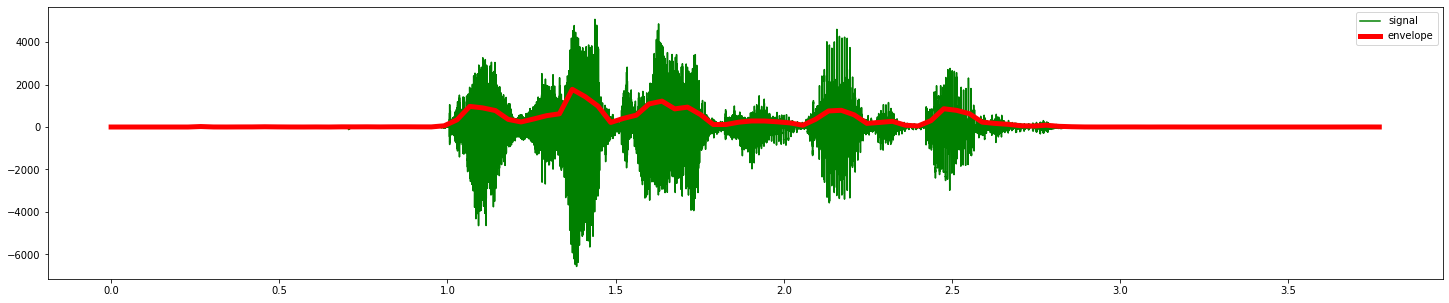

In [21]:
framerate, data = wavfile.read('03-01-05-01-01-01-19_A19.wav')

n = 100
m = len(data) // n
envelope = []

for j in range(n):
    amount = 0
    for k in range(m * j, m * j + m): 
        amount += abs(data[k])
    envelope.append(amount / m)

distributionData = numpy.linspace(0, len(data) / framerate, num=len(data))
distributionEnvelope = numpy.linspace(0, len(data) / framerate, num=len(envelope))

plt.figure(figsize=(25, 5))
plt.plot(distributionData, data, color='green', label='signal')
plt.plot(distributionEnvelope, envelope, color='red', linewidth=5.0, label='envelope')
plt.legend()

## Фильтрация.
### ФНЧ.
Фильтр низкой частоты (ФНЧ, low-pass filter) — подавляет частоты сигнала выше частоты среза данного фильтра.

Пусть $F_d$ — частота дискретизации, частота среза — $F_s$. порядок фильтра — $m$. Тогда вычисляем

$wn = 2 {F_s\over F_d}$

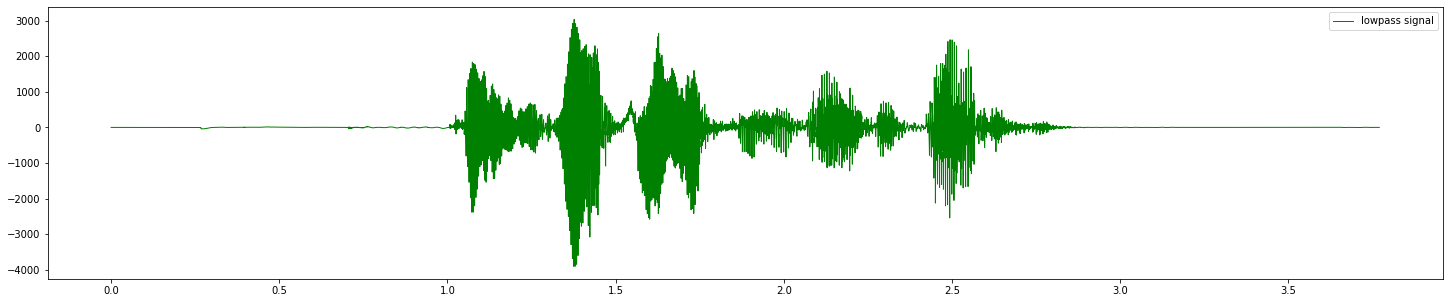

In [16]:
# Фильтр нижних частот
Fs = 1000
Fd = framerate

m = 2
wn = 2 * Fs / Fd
(b, a) = signal.butter(m, wn, btype='lowpass')
filtedData = signal.filtfilt(b, a, data)

wavfile.write('lowpass signal.wav', framerate, filtedData.astype(numpy.int16))

plt.figure(figsize=(25, 5))
plt.plot(distributionData, filtedData, color='green', label='lowpass signal', linewidth=1)
plt.legend()

## Амплитудный детектор сигнал/шум.
Определяем среднее сигнала по амплитуде (без учета знака):

$mid = {1\over N} \sum_{k=0}^{N-1} |x(k)|$

Определяем порог детектора — $Th = \alpha$∗$mid$, где $0 < \alpha < 1$ подбирается экспериментально.

Задаем величину ”провала”(в отсчетах) — $k$. Обозначим $y(i)$ — сигнал после детектирования.

1. Событие ”начало сигнала”. Если $x(i)$ в течении k отсчетов превышает порог, $y(i) = x(i)$.
2. Событие ”окончание сигнала”. Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$.

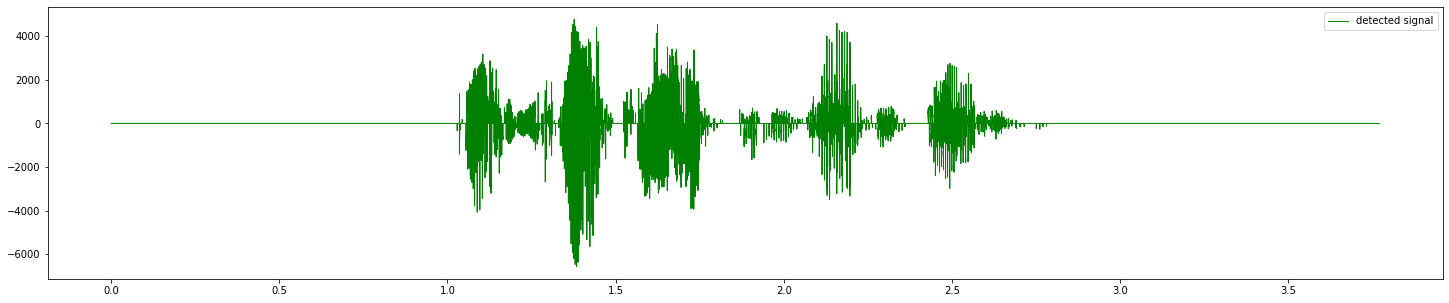

In [28]:
mid = 0
for k in range(len(data)):
    mid += abs(data[k])
mid /= len(data)

a = 0.5 # 0 < a < 1
Th = a * mid

k = 20
y = numpy.zeros(len(data))

counterBSignal = counterESignal = 0
for i in range(len(data)):
    if abs(data[i]) > Th:
        counterBSignal += 1
        counterESignal = 0
        if counterBSignal >= k:
            y[i] = data[i]
    else:
        counterESignal += 1
        counterBSignal = 0

wavfile.write('detected signal.wav', framerate, y.astype(numpy.int16))
        
plt.figure(figsize=(25, 5))
#plt.plot(distributionData, data, color='blue', label='signal', linewidth=1)
plt.plot(distributionData, y, color='green', label='detected signal', linewidth=1)
plt.legend()

## Эхо.

Ревербератор реализован, как набор линий задержки. Число линий задержки $N_L > 8$

Каждая линия задержки имеет свой весовой коэффициент (задается пользователем):

$\alpha_1 > \alpha_2 >...> \alpha{N_L}$

1. Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.
2. Желаемое соотношение между ”сухим”и обработанным сигналом задается коэффициентом применимости γ.
3. Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка D1, а величины остальных определяются автоматически через нее:

$D_i = D_1$ $2{{1-i}\over N_L}, i = 2,...,N_L$.

Для готовой конфигурации пользователь вручную задает последовательность
$D_1 > D_2 >...> D_{N_L}$

Начальное значение $D_1$ определяется геометрией помещения, и является расстоянием, пройденным звуком (скорость 335 м/сек) от точки излучения до ближайшего препятствия.

In [27]:
distance = 20.0 / 335.0
soundSpeed = 335

g = 0.8
N = 8

D = [0] * N
a = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

D[0] = distance
for i in range(1, N):
    D[i] = D[0] * (pow(2, ((-i) / N)))

processedData = numpy.zeros(int((numpy.sum(D) + len(data) / framerate + 1) * framerate))
for i in range(len(data) - 1):
    amount = 0
    for j in range(N):
        amount += D[j]
        processedData[i + int(amount * framerate)] += data[i] * a[j]
        
Fs = 1000
Fd = framerate

m = 1
wn = 2 * Fs / Fd
(b, a) = signal.butter(m, wn, btype='lowpass')
echo = signal.filtfilt(b, a, processedData) * g

for i in range(len(data)):
    echo[i] += data[i]
    
wavfile.write('echo signal.wav', framerate, echo.astype(numpy.int16))

### Эффект ”Distortion”
Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i) i = 0,1, \dots, N - 1$. Пользователь задает порог — $Th$ и максимальное значение сигнала $Max \gt Th$.

Тогда $Y(i) = 
 \begin{cases} x(i), |x(i)| \leq Th, \\ Max * sign(x(i)), |x(i)| \gt Th
 \end{cases}
$

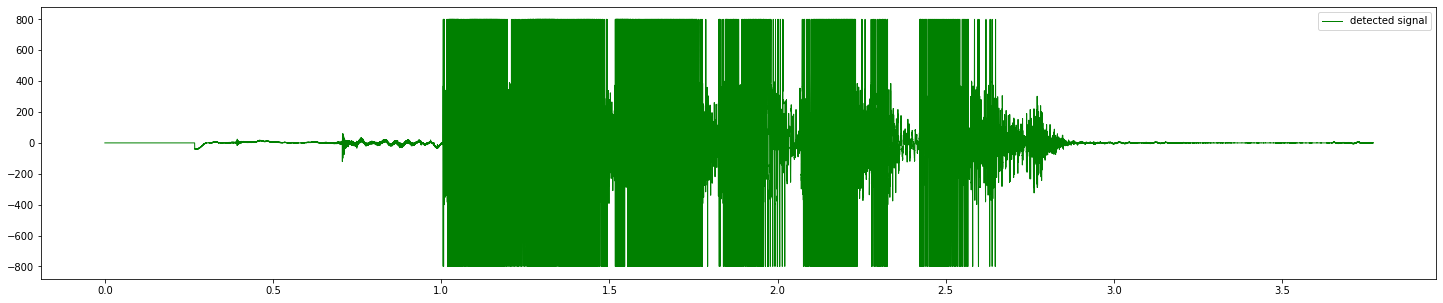

In [25]:
# Distortion
y = numpy.zeros(len(data))

Th = 400
Max = 800

for i in range(len(data)):
    if abs(data[i]) <= Th:
        y[i] = data[i]
    else:
        y[i] = Max * numpy.sign(data[i])
        
wavfile.write('distortion signal.wav', framerate, y.astype(numpy.int16))

plt.figure(figsize=(25, 5))
plt.plot(distributionData, y, color='green', label='detected signal', linewidth=1)
plt.legend()

### Вывод.

В ходе выполнения лабораторной работы были изучены возможности библиотек Python. С их помощью были реализованы способы цифровой обработки сигналов. Также были изучены принципы работы с Jupyter Notebook, такие как возможность считывания, запись и визуализация аудиосигналов. 